In [1]:
import pandas as pd
import sys
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

# 1. Preparing SALE Data for Tableau

In [330]:
clustered = pd.read_csv("Data/202001_android_sale_clustered.csv", index_col='Marketing_Cloud_Visitor_ID')
clustered.head(2)

,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability
Marketing_Cloud_Visitor_ID,,,,,
00001292048436699241321243779438039393,-5.116381,4.755611,1.879831,4,1.000000
00001766658062693463507628179973799683,-1.362855,-5.710967,2.196569,6,0.822321


In [331]:
clustered = clustered[clustered.label_probability>=0.95]
df1 = pd.read_csv('Data/202001_android_data_cleansed.csv', index_col='Marketing_Cloud_Visitor_ID')
df = pd.merge(clustered, df1, on='Marketing_Cloud_Visitor_ID', how='left')
df.head(2)

,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability,ad_pay_to_publish,ad_published,blog-detail,confirm_delete_ad,detail,...,Lead_Confirmation_eMail_madrid,Lead_Counteroffer_eMail_barcelona,Lead_Counteroffer_eMail_big,Lead_Counteroffer_eMail_little,Lead_Counteroffer_eMail_madrid,total_active_days,mean_inactive_days,max_inactive_days,min_inactive_days,n_of_user_ids
Marketing_Cloud_Visitor_ID,,,,,,,,,,,,,,,,,,,,,
00001292048436699241321243779438039393,-5.116381,4.755611,1.879831,4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,15.0,18.0,12.0,0.0
00002144020836140323726002154860698271,-0.918088,-6.077659,3.460269,6,1.0,0.0,0.0,0.0,0.0,63.0,...,0.0,0.0,0.0,0.0,0.0,11.0,2.0,4.0,1.0,0.0


In [332]:
df['total_leads'] = df['Lead_Confirmation_eMailSALE'] + df['Lead_CallphoneSALE'] + df['Lead_Counteroffer_eMailSALE']# remove columns with SALE data and hybrid columns 
# only RENT features stay, when the split exists
SALE_cols = [col for col in df.columns if ('SALE' in col) & ('Lead' not in col) & ('leads' not in col)]
RENT_cols = [col for col in df.columns if ('RENT' in col) & ('Lead' not in col) & ('leads' not in col)]
to_remove = SALE_cols + RENT_cols
to_remove = [col for col in to_remove if col not in ['matchesSALE','micrositeSALE']]

In [333]:
df = df.drop(columns=to_remove)
print(df.shape)

(135958, 78)


In [334]:
# remove zero columns
features = (df != 0).any(axis=0)
print('Data set shape will be:')
print(df.loc[:, features].shape)
print('after removing zeroes columns')
df = df.loc[:, features]

Data set shape will be:
(135958, 75)
after removing zeroes columns


In [335]:
# remove columns that are not actions 
df_aux = df.copy()
to_remove1 = ['total_active_days',
 'mean_inactive_days',
 'max_inactive_days',
 'min_inactive_days',
 'n_of_user_ids']
df_aux = df_aux.drop(columns=to_remove1)

In [336]:
#remove all zero users
n = len(list(df_aux.columns))
non_bounces = (df_aux == 0).sum(axis=1).to_frame(name='perc_of_zeroes')
df_aux = pd.merge(df_aux, non_bounces, how='inner', on='Marketing_Cloud_Visitor_ID')
df_aux['perc_of_zeroes'] = round ( (df_aux['perc_of_zeroes']/n)*100, 2 )
print('Dataset shape will be:')
print(df_aux[df_aux.perc_of_zeroes!=100].shape)
print('after removing rows with all 0 features')

Dataset shape will be:
(135958, 71)
after removing rows with all 0 features


In [337]:
df_aux = df_aux[df_aux.perc_of_zeroes<=97]
df1 = df_aux.drop(columns=['perc_of_zeroes'])
print('Dataset shape has shape:')
print(df1.shape)
print('after removing users with very low engagement')

Dataset shape has shape:
(135958, 70)
after removing users with very low engagement


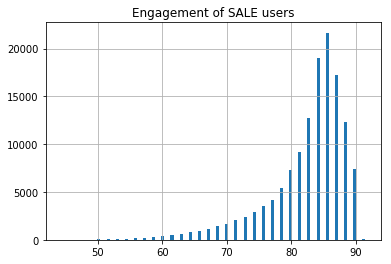

In [338]:
df_aux.perc_of_zeroes.hist(bins=100)
plt.title('Engagement of SALE users')
plt.show()

In [339]:
df2 = pd.merge(df1, df[to_remove1], on='Marketing_Cloud_Visitor_ID', how='left')

In [340]:
df2.head(2)

,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability,ad_pay_to_publish,ad_published,blog-detail,confirm_delete_ad,detail,...,Lead_Counteroffer_eMail_barcelona,Lead_Counteroffer_eMail_big,Lead_Counteroffer_eMail_little,Lead_Counteroffer_eMail_madrid,total_leads,total_active_days,mean_inactive_days,max_inactive_days,min_inactive_days,n_of_user_ids
Marketing_Cloud_Visitor_ID,,,,,,,,,,,,,,,,,,,,,
00001292048436699241321243779438039393,-5.116381,4.755611,1.879831,4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,15.0,18.0,12.0,0.0
00002144020836140323726002154860698271,-0.918088,-6.077659,3.460269,6,1.0,0.0,0.0,0.0,0.0,63.0,...,0.0,0.0,0.0,0.0,1.0,11.0,2.0,4.0,1.0,0.0


In [191]:
#df2.to_excel('Data/Complements/tableau_dataset_SALE.xlsx', index=True)

# 2. Preparing RENT Data for Tableau

In [3]:
# UMAP coordinates with clustering labels
clustered = pd.read_csv("Data/202001_android_rent_clustered_final.csv", index_col='Marketing_Cloud_Visitor_ID')
clustered.head(2)

,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability
Marketing_Cloud_Visitor_ID,,,,,
00000107708722978450827756473807907358,1.862862,-3.838513,3.362385,4.0,0.000000
00000136845845092372076348413986631894,2.388601,-0.954339,1.747901,8.0,0.914677


In [4]:
clustered = clustered[clustered.label_probability>=0.95]

In [5]:
# all features
df1 = pd.read_csv('Data/202001_android_data_cleansed.csv', index_col='Marketing_Cloud_Visitor_ID')
df1.head(2)

,ad_pay_to_publish,ad_published,blog-detail,confirm_delete_ad,detail,detail_map,forgot_password,general,homepage,login,...,Lead_Confirmation_eMail_madrid,Lead_Counteroffer_eMail_barcelona,Lead_Counteroffer_eMail_big,Lead_Counteroffer_eMail_little,Lead_Counteroffer_eMail_madrid,total_active_days,mean_inactive_days,max_inactive_days,min_inactive_days,n_of_user_ids
Marketing_Cloud_Visitor_ID,,,,,,,,,,,,,,,,,,,,,
00000107708722978450827756473807907358,0.0,0.0,0.0,0.0,57.0,5.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,17.0,2.0,6.0,1.0,1.0
00000136845845092372076348413986631894,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,16.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,7.0,17.0,1.0,0.0


In [6]:
df1.shape

(744829, 96)

In [8]:
df = pd.merge(clustered, df1, on='Marketing_Cloud_Visitor_ID', how='left')
df.head(2)

,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability,ad_pay_to_publish,ad_published,blog-detail,confirm_delete_ad,detail,...,Lead_Confirmation_eMail_madrid,Lead_Counteroffer_eMail_barcelona,Lead_Counteroffer_eMail_big,Lead_Counteroffer_eMail_little,Lead_Counteroffer_eMail_madrid,total_active_days,mean_inactive_days,max_inactive_days,min_inactive_days,n_of_user_ids
Marketing_Cloud_Visitor_ID,,,,,,,,,,,,,,,,,,,,,
00000630229631893432133166794739701486,-1.069099,5.991518,1.310087,9.0,0.994149,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2.0,14.0,26.0,3.0,0.0
00001056477770175460876584629700827747,1.951116,1.429780,-0.077692,8.0,1.000000,0.0,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,7.0,4.0,14.0,1.0,0.0


Alternativa 1: para guardar acciones totales en lugar de por transacción

In [11]:
df['total_leads'] = df['Lead_Confirmation_eMailRENT']+df['Lead_CallphoneRENT']+df['Lead_Counteroffer_eMailRENT']
# remove columns with SALE data and hybrid columns 
# only RENT features stay, when the split exists
SALE_cols = [col for col in df.columns if ('SALE' in col) & ('Lead' not in col) & ('leads' not in col)]
RENT_cols = [col for col in df.columns if ('RENT' in col) & ('Lead' not in col) & ('leads' not in col)]
to_remove = SALE_cols + RENT_cols
to_remove.remove('matchesRENT')

In [12]:
to_remove

['detailSALE',
 'detail_mapSALE',
 'homepageSALE',
 'my_alerts_listSALE',
 'favouritesSALE',
 'matchesSALE',
 'micrositeSALE',
 'recommendedSALE',
 'suggestedSALE',
 'listSALE',
 'mapSALE',
 'Ad_FavouritedSALE',
 'Alert_AddedSALE',
 'detailRENT',
 'detail_mapRENT',
 'homepageRENT',
 'my_alerts_listRENT',
 'favouritesRENT',
 'micrositeRENT',
 'recommendedRENT',
 'suggestedRENT',
 'listRENT',
 'mapRENT',
 'Ad_FavouritedRENT',
 'Alert_AddedRENT']

FINE alternativa 1

Alternativa 2: para guardar acciones por transacción

In [181]:
df['total_leadsRENT'] = df['Lead_Confirmation_eMailRENT']+df['Lead_CallphoneRENT']+df['Lead_Counteroffer_eMailRENT']
# remove columns with SALE data and hybrid columns 
# only RENT features stay, when the split exists
SALE_cols = [col for col in df.columns if ('SALE' in col) & ('Lead' not in col) & ('leads' not in col)]
to_remove = [col.replace('SALE','') for col in SALE_cols] + SALE_cols
to_remove = [col for col in to_remove if col in df.columns]
to_remove

['detail',
 'detail_map',
 'homepage',
 'my_alerts_list',
 'favourites',
 'recommended',
 'suggested',
 'list',
 'map',
 'Ad_Favourited',
 'Alert_Added',
 'detailSALE',
 'detail_mapSALE',
 'homepageSALE',
 'my_alerts_listSALE',
 'favouritesSALE',
 'matchesSALE',
 'micrositeSALE',
 'recommendedSALE',
 'suggestedSALE',
 'listSALE',
 'mapSALE',
 'Ad_FavouritedSALE',
 'Alert_AddedSALE']

In [199]:
# check that there is no sale data in rent data
for col in SALE_cols:
    if df[df[col]!=0].shape[0]!=0:
        print(col)
        print(df[df[col]!=0].shape[0])

detailSALE
7960
detail_mapSALE
738
homepageSALE
3890
my_alerts_listSALE
923
favouritesSALE
433
matchesSALE
599
micrositeSALE
116
recommendedSALE
32
suggestedSALE
126
listSALE
10561
mapSALE
497
Ad_FavouritedSALE
151
Alert_AddedSALE
110


Fine Alternativa 2

In [13]:
# check for some NAa in columns :/
for col in df.columns:
    if df[df[col].isna()].shape[0]!=0:
        print(col)

In [14]:
df = df.drop(columns=to_remove)

In [15]:
df.shape

(124725, 77)

In [16]:
# remove zero columns
features = (df != 0).any(axis=0)
print('Data set shape will be:')
print(df.loc[:, features].shape)
print('after removing zeroes columns')
df = df.loc[:, features]
# remove columns that are not actions 
df_aux = df.copy()
to_remove = ['total_active_days',
 'mean_inactive_days',
 'max_inactive_days',
 'min_inactive_days',
 'n_of_user_ids']
df_aux = df_aux.drop(columns=to_remove)
#remove all zero users
n = len(list(df_aux.columns))
non_bounces = (df_aux == 0).sum(axis=1).to_frame(name='perc_of_zeroes')
df_aux = pd.merge(df_aux, non_bounces, how='inner', on='Marketing_Cloud_Visitor_ID')
df_aux['perc_of_zeroes'] = round ( (df_aux['perc_of_zeroes']/n)*100, 2 )
print('Dataset shape will be:')
print(df_aux[df_aux.perc_of_zeroes!=100].shape)
print('after removing rows with all 0 features')

Data set shape will be:
(124725, 73)
after removing zeroes columns
Dataset shape will be:
(124725, 69)
after removing rows with all 0 features


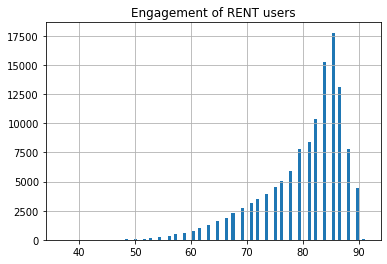

In [17]:
df_aux.perc_of_zeroes.hist(bins=100)
plt.title('Engagement of RENT users')
plt.show()

In [18]:
del df_aux['perc_of_zeroes']

In [19]:
df1 = pd.merge(df_aux, df[to_remove], on='Marketing_Cloud_Visitor_ID', how='left')

In [20]:
df1.head(2)

,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability,ad_pay_to_publish,ad_published,confirm_delete_ad,detail,detail_map,...,Lead_Counteroffer_eMail_barcelona,Lead_Counteroffer_eMail_big,Lead_Counteroffer_eMail_little,Lead_Counteroffer_eMail_madrid,total_leads,total_active_days,mean_inactive_days,max_inactive_days,min_inactive_days,n_of_user_ids
Marketing_Cloud_Visitor_ID,,,,,,,,,,,,,,,,,,,,,
00000630229631893432133166794739701486,-1.069099,5.991518,1.310087,9.0,0.994149,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,14.0,26.0,3.0,0.0
00001056477770175460876584629700827747,1.951116,1.429780,-0.077692,8.0,1.000000,0.0,0.0,0.0,13.0,1.0,...,0.0,0.0,0.0,0.0,0.0,7.0,4.0,14.0,1.0,0.0


# 03. Median and Mean User per Cluster

In [22]:
df = df1.reset_index('Marketing_Cloud_Visitor_ID')

In [23]:
df.head(2)

,Marketing_Cloud_Visitor_ID,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability,ad_pay_to_publish,ad_published,confirm_delete_ad,detail,...,Lead_Counteroffer_eMail_barcelona,Lead_Counteroffer_eMail_big,Lead_Counteroffer_eMail_little,Lead_Counteroffer_eMail_madrid,total_leads,total_active_days,mean_inactive_days,max_inactive_days,min_inactive_days,n_of_user_ids
0,00000630229631893432133166794739701486,-1.069099,5.991518,1.310087,9.0,0.994149,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2.0,14.0,26.0,3.0,0.0
1,00001056477770175460876584629700827747,1.951116,1.429780,-0.077692,8.0,1.000000,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,7.0,4.0,14.0,1.0,0.0


In [24]:
avg_aux = df.groupby('label').agg(umap_mean_1=pd.NamedAgg(column='umap_dim_1', aggfunc='mean')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')
avg_aux = df.groupby('label').agg(umap_mean_2=pd.NamedAgg(column='umap_dim_2', aggfunc='mean')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')
avg_aux = df.groupby('label').agg(umap_mean_3=pd.NamedAgg(column='umap_dim_3', aggfunc='mean')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')

In [25]:
df.head(2)

,Marketing_Cloud_Visitor_ID,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability,ad_pay_to_publish,ad_published,confirm_delete_ad,detail,...,Lead_Counteroffer_eMail_madrid,total_leads,total_active_days,mean_inactive_days,max_inactive_days,min_inactive_days,n_of_user_ids,umap_mean_1,umap_mean_2,umap_mean_3
0,00000630229631893432133166794739701486,-1.069099,5.991518,1.310087,9.0,0.994149,0.0,0.0,0.0,2.0,...,0.0,0.0,2.0,14.0,26.0,3.0,0.0,-1.734590,6.844519,2.262474
1,00001056477770175460876584629700827747,1.951116,1.429780,-0.077692,8.0,1.000000,0.0,0.0,0.0,13.0,...,0.0,0.0,7.0,4.0,14.0,1.0,0.0,2.039103,0.735141,-0.525626


In [26]:
df.loc[( round(df.umap_dim_1, 1)==round(df.umap_mean_1, 1) ) & 
       ( round(df.umap_dim_2, 1)==round(df.umap_mean_2, 1) ) &
       ( round(df.umap_dim_3, 1)==round(df.umap_mean_3, 1) ), 
       ('center_mean')] = 1

In [27]:
df[df['center_mean']==1].label.unique()

array([0., 7., 5., 6.])

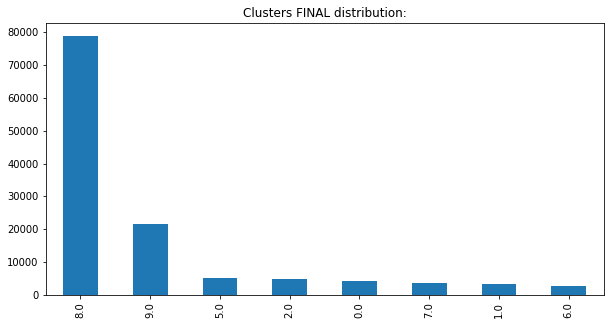

In [28]:
plt.figure(figsize=(10, 5))
plt.title('Clusters FINAL distribution:')
pd.value_counts(df['label'], normalize=False).plot.bar()
plt.show()

In [29]:
avg_aux = df.groupby('label').agg(umap_median_1=pd.NamedAgg(column='umap_dim_1', aggfunc='median')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')
avg_aux = df.groupby('label').agg(umap_median_2=pd.NamedAgg(column='umap_dim_2', aggfunc='median')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')
avg_aux = df.groupby('label').agg(umap_median_3=pd.NamedAgg(column='umap_dim_3', aggfunc='median')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')
df.loc[( round(df.umap_dim_1, 1)==round(df.umap_median_1, 1) ) & 
       ( round(df.umap_dim_2, 1)==round(df.umap_median_2, 1) ) &
       ( round(df.umap_dim_3, 1)==round(df.umap_median_3, 1) ), 
       ('center_median')] = 1

In [30]:
df[df['center_median']==1].label.unique()

array([1., 0., 7., 5., 6., 8., 9.])

In [31]:
avg_aux = df.groupby('label').agg(umap_max_1=pd.NamedAgg(column='umap_dim_1', aggfunc='max')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')
avg_aux = df.groupby('label').agg(umap_max_2=pd.NamedAgg(column='umap_dim_2', aggfunc='max')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')
avg_aux = df.groupby('label').agg(umap_max_3=pd.NamedAgg(column='umap_dim_3', aggfunc='max')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')
df.loc[( round(df.umap_dim_1, 1)==round(df.umap_max_1, 1) ) & 
       ( round(df.umap_dim_2, 1)==round(df.umap_max_2, 1) ) &
       ( round(df.umap_dim_3, 1)==round(df.umap_max_3, 1) ), 
       ('center_max')] = 1

In [32]:
df[df['center_max']==1].label.unique()

array([], dtype=float64)

In [33]:
avg_aux = df.groupby('label').agg(umap_min_1=pd.NamedAgg(column='umap_dim_1', aggfunc='min')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')
avg_aux = df.groupby('label').agg(umap_min_2=pd.NamedAgg(column='umap_dim_2', aggfunc='min')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')
avg_aux = df.groupby('label').agg(umap_min_3=pd.NamedAgg(column='umap_dim_3', aggfunc='min')).reset_index()
df = pd.merge(df, avg_aux, how='left', on='label')
df.loc[( round(df.umap_dim_1, 1)==round(df.umap_min_1, 1) ) & 
       ( round(df.umap_dim_2, 1)==round(df.umap_min_2, 1) ) &
       ( round(df.umap_dim_3, 1)==round(df.umap_min_3, 1) ), 
       ('center_min')] = 1

In [34]:
df[df['center_min']==1].label.unique()

array([], dtype=float64)

In [35]:
#df.to_excel('Data/Complements/tableau_dataset_SALE.xlsx', index=False)

# Add source features

In [101]:
#df = pd.read_excel('Data/Complements/tableau_dataset_RENT.xlsx')

In [36]:
df.head(2)

,Marketing_Cloud_Visitor_ID,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability,ad_pay_to_publish,ad_published,confirm_delete_ad,detail,...,umap_median_3,center_median,umap_max_1,umap_max_2,umap_max_3,center_max,umap_min_1,umap_min_2,umap_min_3,center_min
0,00000630229631893432133166794739701486,-1.069099,5.991518,1.310087,9.0,0.994149,0.0,0.0,0.0,2.0,...,1.871991,NaN,1.344472,9.381427,5.003418,NaN,-3.762262,2.972539,0.631834,NaN
1,00001056477770175460876584629700827747,1.951116,1.429780,-0.077692,8.0,1.000000,0.0,0.0,0.0,13.0,...,-0.134685,NaN,3.983262,3.791812,5.172009,NaN,-0.381318,-4.275963,-6.987524,NaN


In [37]:
source = pd.read_csv('Data/Complements/202001_android_visits_source.csv')

In [38]:
source = source.fillna(0)

In [39]:
source.head(2)

,Marketing_Cloud_Visitor_ID,_Direct,_Retargeting,Cross_Sites,Display,Email,Metasearch,Others,Paid_Search,Push_Notifications,Social_Media_Paid
0,00000051745022542041818069014855750667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000107708722978450827756473807907358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0


In [40]:
df1 = pd.merge(df, source, on='Marketing_Cloud_Visitor_ID', how='left')

In [41]:
df1 = df1.fillna(0)

In [42]:
df1.shape

(124725, 100)

Add total visits

In [43]:
visits = pd.read_csv('Data/AdobeData/android_daily_visits_per_user_202001.csv').drop(columns=['Unnamed: 0'])

In [44]:
visits.head(2)

,Datetime,Marketing Cloud Visitor ID,Visits
0,2020-01-01 00:00:00,00000000000000000000000000000000000000,0
1,2020-01-01 00:00:00,00000407524030170034329152187891187137,2


In [45]:
visits.columns = visits.columns.str.replace(' ', '_')
visits.columns = visits.columns.str.replace('(', '_')
visits.columns = visits.columns.str.replace(')', '_')
visits = visits[visits.Marketing_Cloud_Visitor_ID!='00000000000000000000000000000000000000']
# remove time from Datetime columns
visits.loc[:, ('Date')] = pd.DatetimeIndex(visits.Datetime).normalize()

In [46]:
visits = visits.groupby('Marketing_Cloud_Visitor_ID').agg(total_visits=pd.NamedAgg(column='Visits', aggfunc='sum')).reset_index()

In [47]:
df2 = pd.merge(df1, visits, how='left', on='Marketing_Cloud_Visitor_ID')

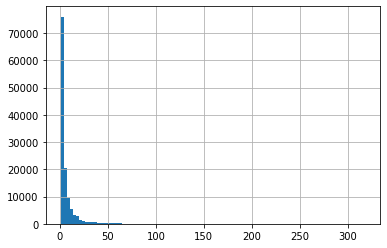

In [48]:
df2.total_visits.hist(bins=100)
plt.show()

In [49]:
df2[df2.total_visits>=250].total_active_days.unique()

array([30., 31.])

In [115]:
#df1.to_excel('Data/Complements/tableau_dataset_RENT.xlsx', index=False)

# Add median user for missing clusters

In [122]:
#df = pd.read_excel('Data/Complements/tableau_dataset_RENT.xlsx')

In [50]:
df = df2.copy()

In [51]:
list(df.columns)

['Marketing_Cloud_Visitor_ID',
 'umap_dim_1',
 'umap_dim_2',
 'umap_dim_3',
 'label',
 'label_probability',
 'ad_pay_to_publish',
 'ad_published',
 'confirm_delete_ad',
 'detail',
 'detail_map',
 'forgot_password',
 'general',
 'homepage',
 'login',
 'my_ads',
 'my_alerts_list',
 'my_showcase',
 'privacy_policy',
 'radar',
 'search_filter',
 'search_filter_location',
 'search_filter_suggest',
 'signup',
 'terms_and_conditions',
 'validate_phone',
 'Lead_Confirmation_eMail',
 'Ad_Filter_Used',
 'Lead_Counteroffer_eMail',
 'Ad_Discarded',
 'Ad_Recovered',
 'Signed_Out',
 'Lead_Callphone',
 'Signed_In',
 'Alert_Added',
 'Ad_Contact_Button',
 'Form_Error',
 'Signed_Up',
 'Ad_Favourited',
 'Ad_Unfavourited',
 'POI_Clicked',
 'Label_Clicked',
 'Alert_Guest_Accepted',
 'Alert_Guest_Declined',
 'Alert_Guest_Automatically',
 'Favourite_Clicked',
 'Unfavourite_Clicked',
 'matchesRENT',
 'favourites',
 'recommended',
 'suggested',
 'list',
 'map',
 'Lead_CallphoneRENT',
 'Lead_Confirmation_eMailR

In [52]:
df.head(2)

,Marketing_Cloud_Visitor_ID,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability,ad_pay_to_publish,ad_published,confirm_delete_ad,detail,...,_Retargeting,Cross_Sites,Display,Email,Metasearch,Others,Paid_Search,Push_Notifications,Social_Media_Paid,total_visits
0,00000630229631893432133166794739701486,-1.069099,5.991518,1.310087,9.0,0.994149,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,00001056477770175460876584629700827747,1.951116,1.429780,-0.077692,8.0,1.000000,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8


In [53]:
list(df.label.unique())

[9.0, 8.0, 1.0, 7.0, 2.0, 0.0, 5.0, 6.0]

In [54]:
missing_labels = [l for l in list(df.label.unique()) if l not in list(df[df['center_median']==1].label.unique()) ]

In [55]:
missing_labels

[2.0]

In [56]:
for lab in missing_labels:
    df.loc[(df.label==lab) & 
    ( round(df.umap_dim_2, 1)==round(df.umap_median_2, 1) ) &
    ( round(df.umap_dim_3, 1)==round(df.umap_median_3, 1) ), 
      ('center_median')] = 1

In [57]:
df[df['center_median']==1].label.unique()

array([1., 0., 2., 7., 5., 6., 8., 9.])

In [58]:
missing_labels = [l for l in list(df.label.unique()) if l not in list(df[df['center_median']==1].label.unique()) ]

In [59]:
missing_labels

[]

In [60]:
list(df.columns)

['Marketing_Cloud_Visitor_ID',
 'umap_dim_1',
 'umap_dim_2',
 'umap_dim_3',
 'label',
 'label_probability',
 'ad_pay_to_publish',
 'ad_published',
 'confirm_delete_ad',
 'detail',
 'detail_map',
 'forgot_password',
 'general',
 'homepage',
 'login',
 'my_ads',
 'my_alerts_list',
 'my_showcase',
 'privacy_policy',
 'radar',
 'search_filter',
 'search_filter_location',
 'search_filter_suggest',
 'signup',
 'terms_and_conditions',
 'validate_phone',
 'Lead_Confirmation_eMail',
 'Ad_Filter_Used',
 'Lead_Counteroffer_eMail',
 'Ad_Discarded',
 'Ad_Recovered',
 'Signed_Out',
 'Lead_Callphone',
 'Signed_In',
 'Alert_Added',
 'Ad_Contact_Button',
 'Form_Error',
 'Signed_Up',
 'Ad_Favourited',
 'Ad_Unfavourited',
 'POI_Clicked',
 'Label_Clicked',
 'Alert_Guest_Accepted',
 'Alert_Guest_Declined',
 'Alert_Guest_Automatically',
 'Favourite_Clicked',
 'Unfavourite_Clicked',
 'matchesRENT',
 'favourites',
 'recommended',
 'suggested',
 'list',
 'map',
 'Lead_CallphoneRENT',
 'Lead_Confirmation_eMailR

In [61]:
df.to_excel('Data/Complements/tableau_dataset_RENT_new.xlsx', index=False)

# 4. Aha Moments

In [88]:
df = pd.read_excel('Data/Complements/tableau_dataset_RENT.xlsx', index=False)

In [90]:
df.head()

,Marketing_Cloud_Visitor_ID,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability,ad_pay_to_publish,ad_published,blog-detail,confirm_delete_ad,...,umap_median_3,center_median,umap_max_1,umap_max_2,umap_max_3,center_max,umap_min_1,umap_min_2,umap_min_3,center_min
0,00001292048436699241321243779438039393,-5.116381,4.755611,1.879831,4,1.0,0,0,0,0,...,1.040516,NaN,-2.380646,7.665174,3.860200,NaN,-6.894277,-1.627502,-1.057908,NaN
1,00002144020836140323726002154860698271,-0.918088,-6.077659,3.460269,6,1.0,0,0,0,0,...,0.155965,NaN,0.343494,2.302875,8.863924,NaN,-2.444870,-7.481943,-6.547246,NaN
2,00002595388093483582529177107093749157,-0.344919,-7.316287,6.077663,6,1.0,0,0,0,0,...,0.155965,NaN,0.343494,2.302875,8.863924,NaN,-2.444870,-7.481943,-6.547246,NaN
3,00003867902435913144072325234316387032,16.645624,3.405282,3.943762,0,1.0,0,0,0,0,...,3.827763,NaN,17.482931,3.502283,4.137867,NaN,14.603256,3.031966,3.579675,NaN
4,00004099384466733620051134156105329947,-4.703594,4.073564,1.246286,4,1.0,0,0,0,0,...,1.040516,NaN,-2.380646,7.665174,3.860200,NaN,-6.894277,-1.627502,-1.057908,NaN


In [91]:
list(df.columns)

['Marketing_Cloud_Visitor_ID',
 'umap_dim_1',
 'umap_dim_2',
 'umap_dim_3',
 'label',
 'label_probability',
 'ad_pay_to_publish',
 'ad_published',
 'blog-detail',
 'confirm_delete_ad',
 'forgot_password',
 'general',
 'homepage',
 'login',
 'my_ads',
 'my_showcase',
 'privacy_policy',
 'radar',
 'search_filter',
 'search_filter_location',
 'search_filter_suggest',
 'signup',
 'terms_and_conditions',
 'validate_phone',
 'Lead_Confirmation_eMail',
 'Ad_Filter_Used',
 'Lead_Counteroffer_eMail',
 'Ad_Discarded',
 'Ad_Recovered',
 'Signed_Out',
 'Lead_Callphone',
 'Signed_In',
 'Ad_Contact_Button',
 'Form_Error',
 'Signed_Up',
 'Ad_Unfavourited',
 'POI_Clicked',
 'Label_Clicked',
 'Alert_Guest_Accepted',
 'Alert_Guest_Declined',
 'Alert_Guest_Automatically',
 'Favourite_Clicked',
 'Unfavourite_Clicked',
 'detailSALE',
 'detail_mapSALE',
 'homepageSALE',
 'my_alerts_listSALE',
 'favouritesSALE',
 'matchesSALE',
 'micrositeSALE',
 'recommendedSALE',
 'suggestedSALE',
 'listSALE',
 'mapSALE',


In [82]:
def compute_aha_moment(col_aha, df):
    df_aux = pd.DataFrame(columns=['action', 'score', 'label'])
    for lab in list(df.label.unique()):
        cluster = df[df.label==lab]
        # drop zero target
        #cluster = cluster[cluster[col_aha]!=0]
        corr = cluster.corr()
        rec = pd.DataFrame(corr.loc[col_aha]).reset_index()
        rec['label'] = lab
        rec = rec.rename(columns={'index':'action', 
                                  col_aha:'score'})
        rec = rec.dropna()
        rec = rec[rec.score>0]
        rec = rec.sort_values(by='score', ascending=True)
        rec.score = round(rec.score, 2)*100
        df_aux = pd.concat([df_aux, rec])
    df_aha = df_aux.copy()
    return df_aha

In [83]:
df_recurrency = compute_aha_moment(col_aha = 'total_visits', df = df)
df_money = compute_aha_moment(col_aha = 'total_leads', df = df)

In [84]:
df_recurrency['aha_type'] = 'recurrency'
df_money['aha_type'] = 'monetization'

In [85]:
aha_moments = pd.concat([df_money, df_recurrency])

In [76]:
aha_moments[(aha_moments.label==1) & (aha_moments.aha_type=='recurrency')]

,action,score,label,aha_type
75,umap_mean_3,0.0,1,recurrency
78,umap_median_2,0.0,1,recurrency
73,umap_mean_1,0.0,1,recurrency
77,umap_median_1,0.0,1,recurrency
85,umap_min_1,0.0,1,recurrency
33,Alert_Added,0.0,1,recurrency
44,Favourite_Clicked,0.0,1,recurrency
10,forgot_password,0.0,1,recurrency
22,signup,1.0,1,recurrency
50,list,1.0,1,recurrency


In [86]:
aha_moments.to_excel('Data/Complements/202001_android_rent_aha_moments_scoring2.xlsx', index=False)